In [21]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying :class:`~sklearn.decomposition.NMF` and
:class:`~sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a plot of topics, each represented as bar plot
using top few words based on weights.

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).


In [22]:
# based on a sklern example from Olivier Grisel <olivier.grisel@ensta.org>, Lars Buitinck, Chyi-Kwei Yau <chyikwei.yau@gmail.com>; License: BSD 3 clause

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [23]:
n_samples = 4000    # how many sample documents to use
n_features = 3000   # how many of the top words to use as features
n_components = 10   # how many topics to find
n_top_words = 20    # how many of the top words to show when describing a topic

MIN_DF = 10     # absolute minimum document frequency for a word
MAX_DF = 0.95   # Maximum document frequency for a word as a percent of documents in collection

In [24]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [25]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to remove useless terms: the posts are stripped of headers, footers,
# and quoted replies, and common English stopwords, words occurring in
# fewer than MIN_DF document or in at least MAX_DF of the documents.

data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print(f"Loaded {n_samples} of {len(data)} texts from 20 newsgroups. Here's one example:\n")
print(data_samples[0])

Loaded 4000 of 11314 texts from 20 newsgroups. Here's one example:

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.



In [26]:
# Extract tf-idf features for NMF...
tfidf_vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model to the data
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
print(f"NMF model fit using {n_features} tf-idf features on {n_samples} documents")

NMF model fit using 3000 tf-idf features on 4000 documents


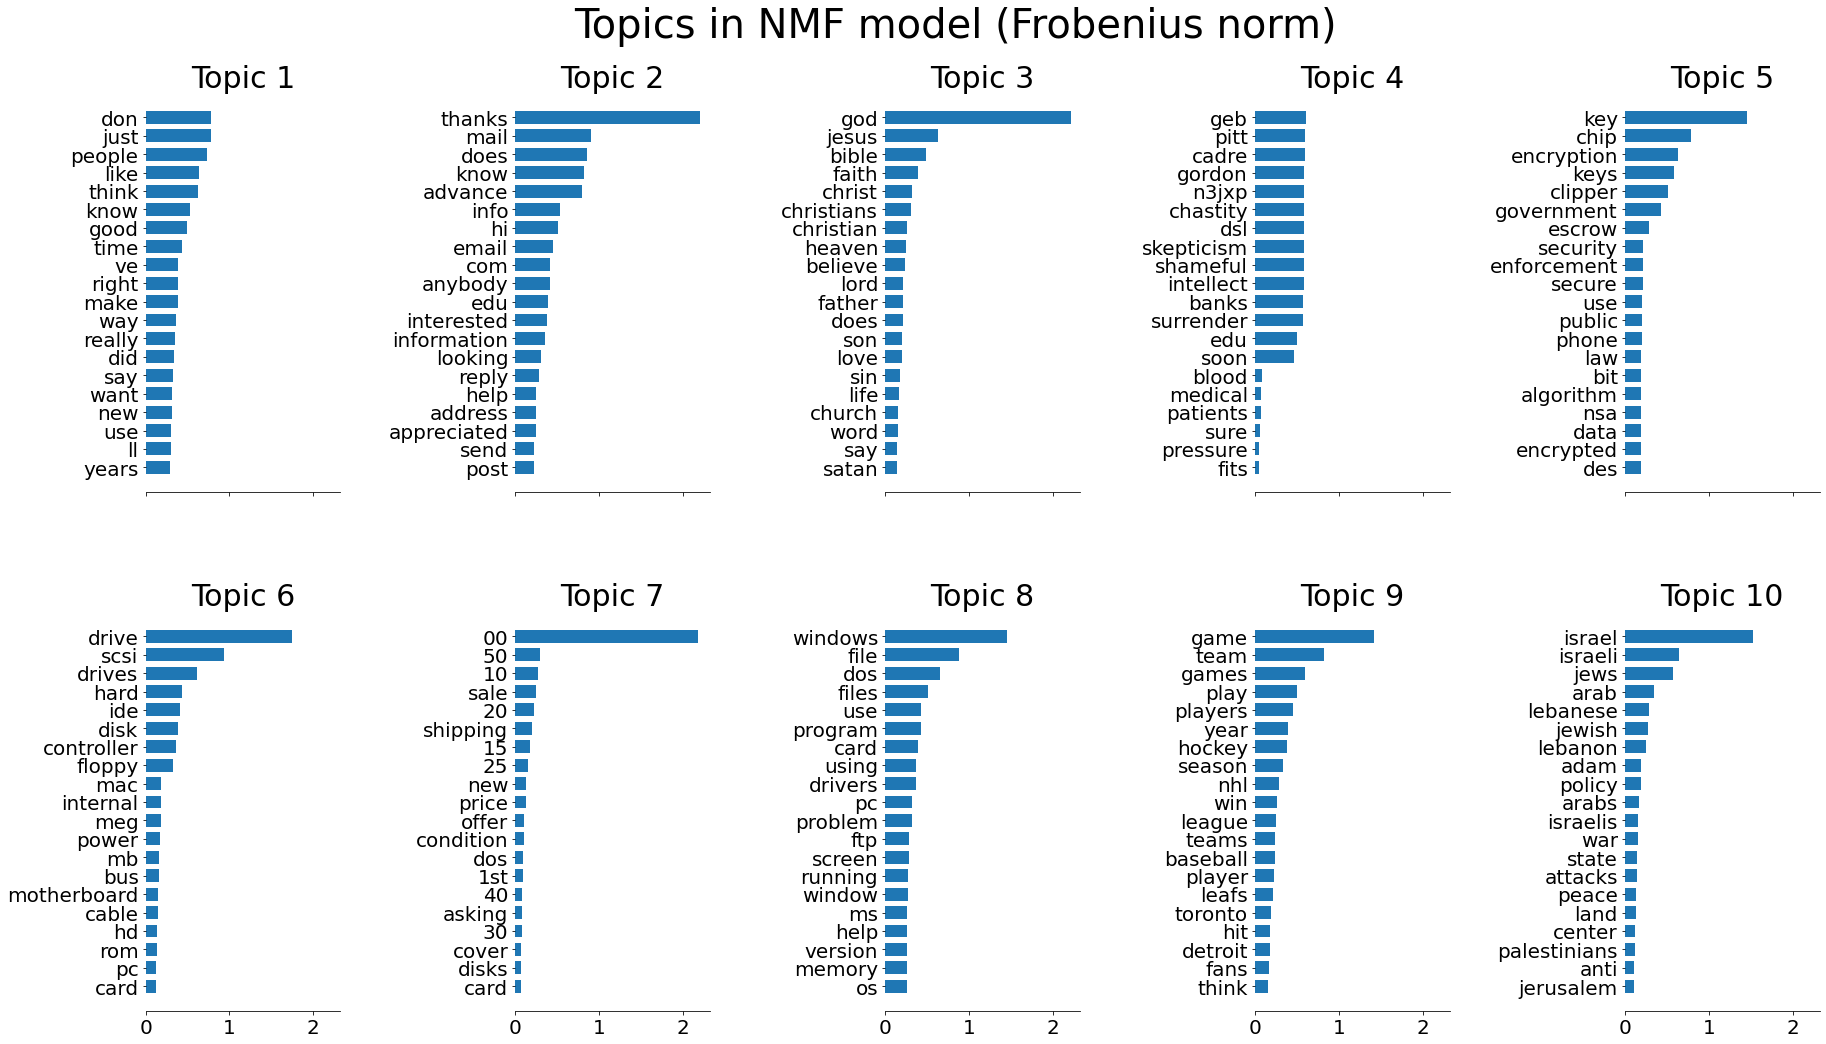

In [27]:
# display top words in each topic
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words, 'Topics in NMF model (Frobenius norm)')


Fitting NMF model (generalized KL divergence) with tf-idf features and 3000 featuress


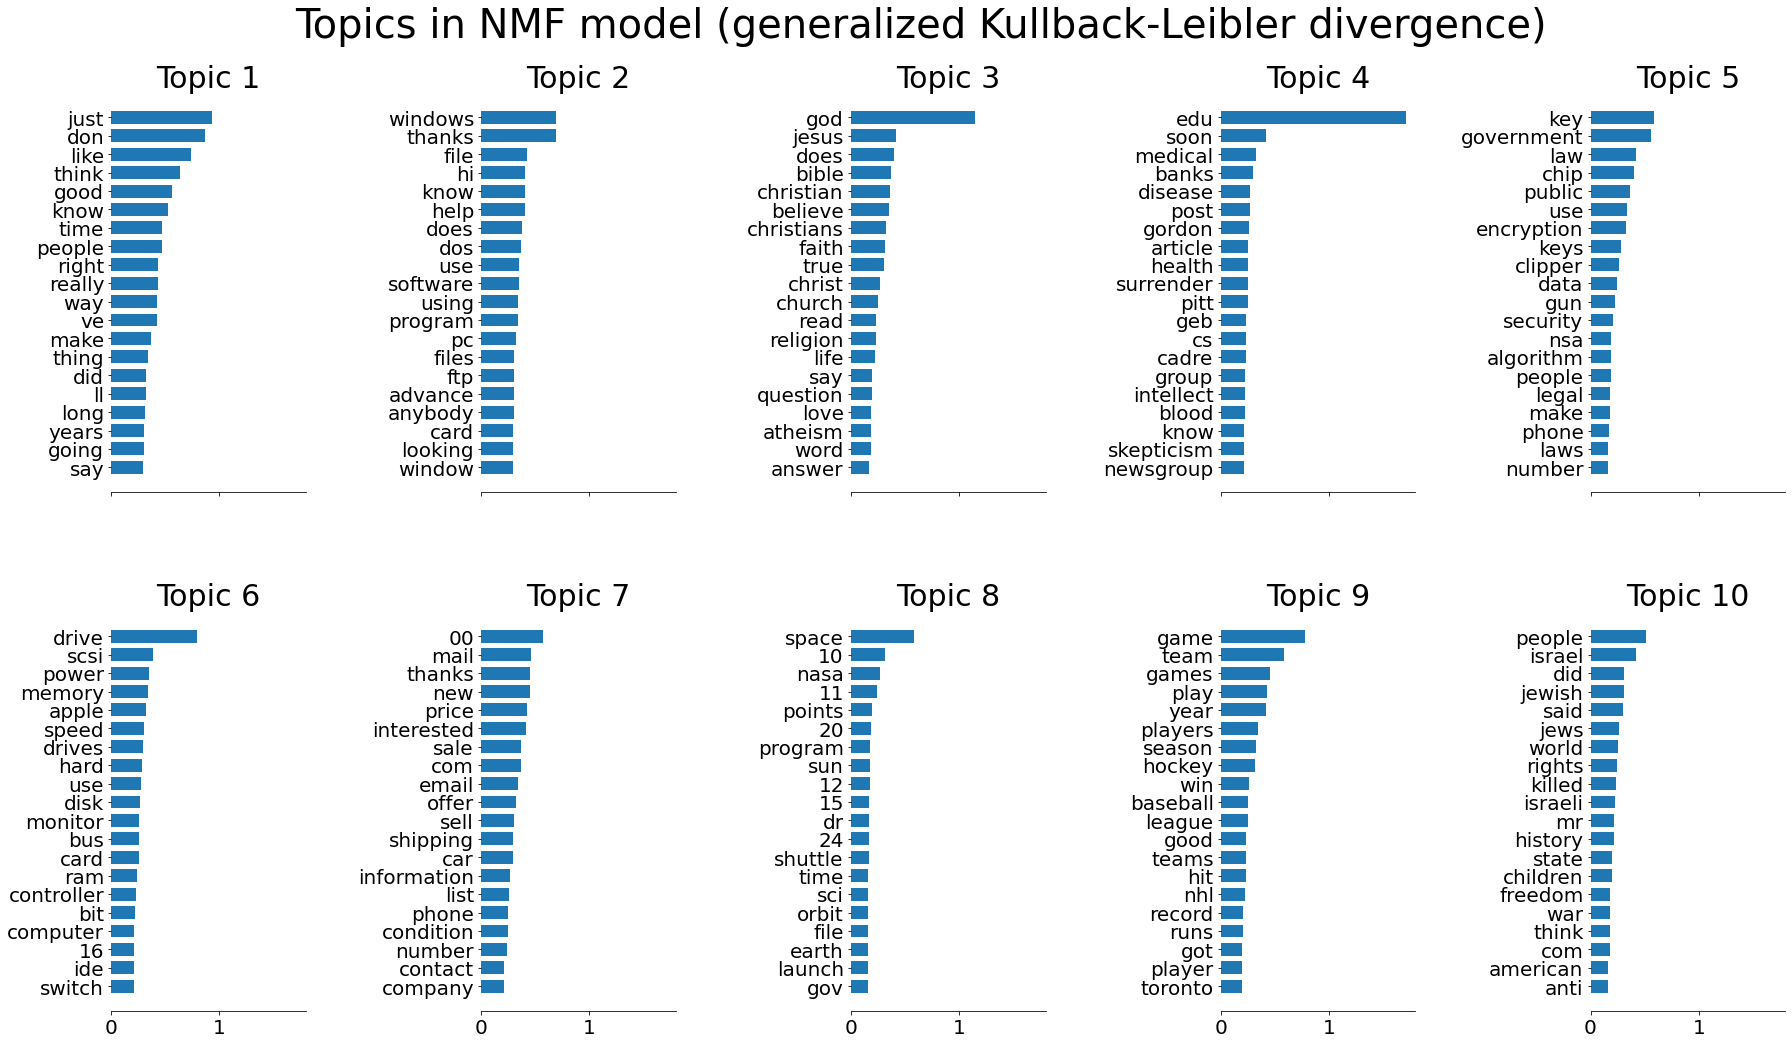

In [28]:
# Fit the NMF model
print(f"\nFitting NMF model (generalized KL divergence) with tf-idf features and {n_features} featuress" ) 
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

Extracting tf features for LDA...


 Fitting LDA models with tf features, n_samples=4000 and n_features=3000...


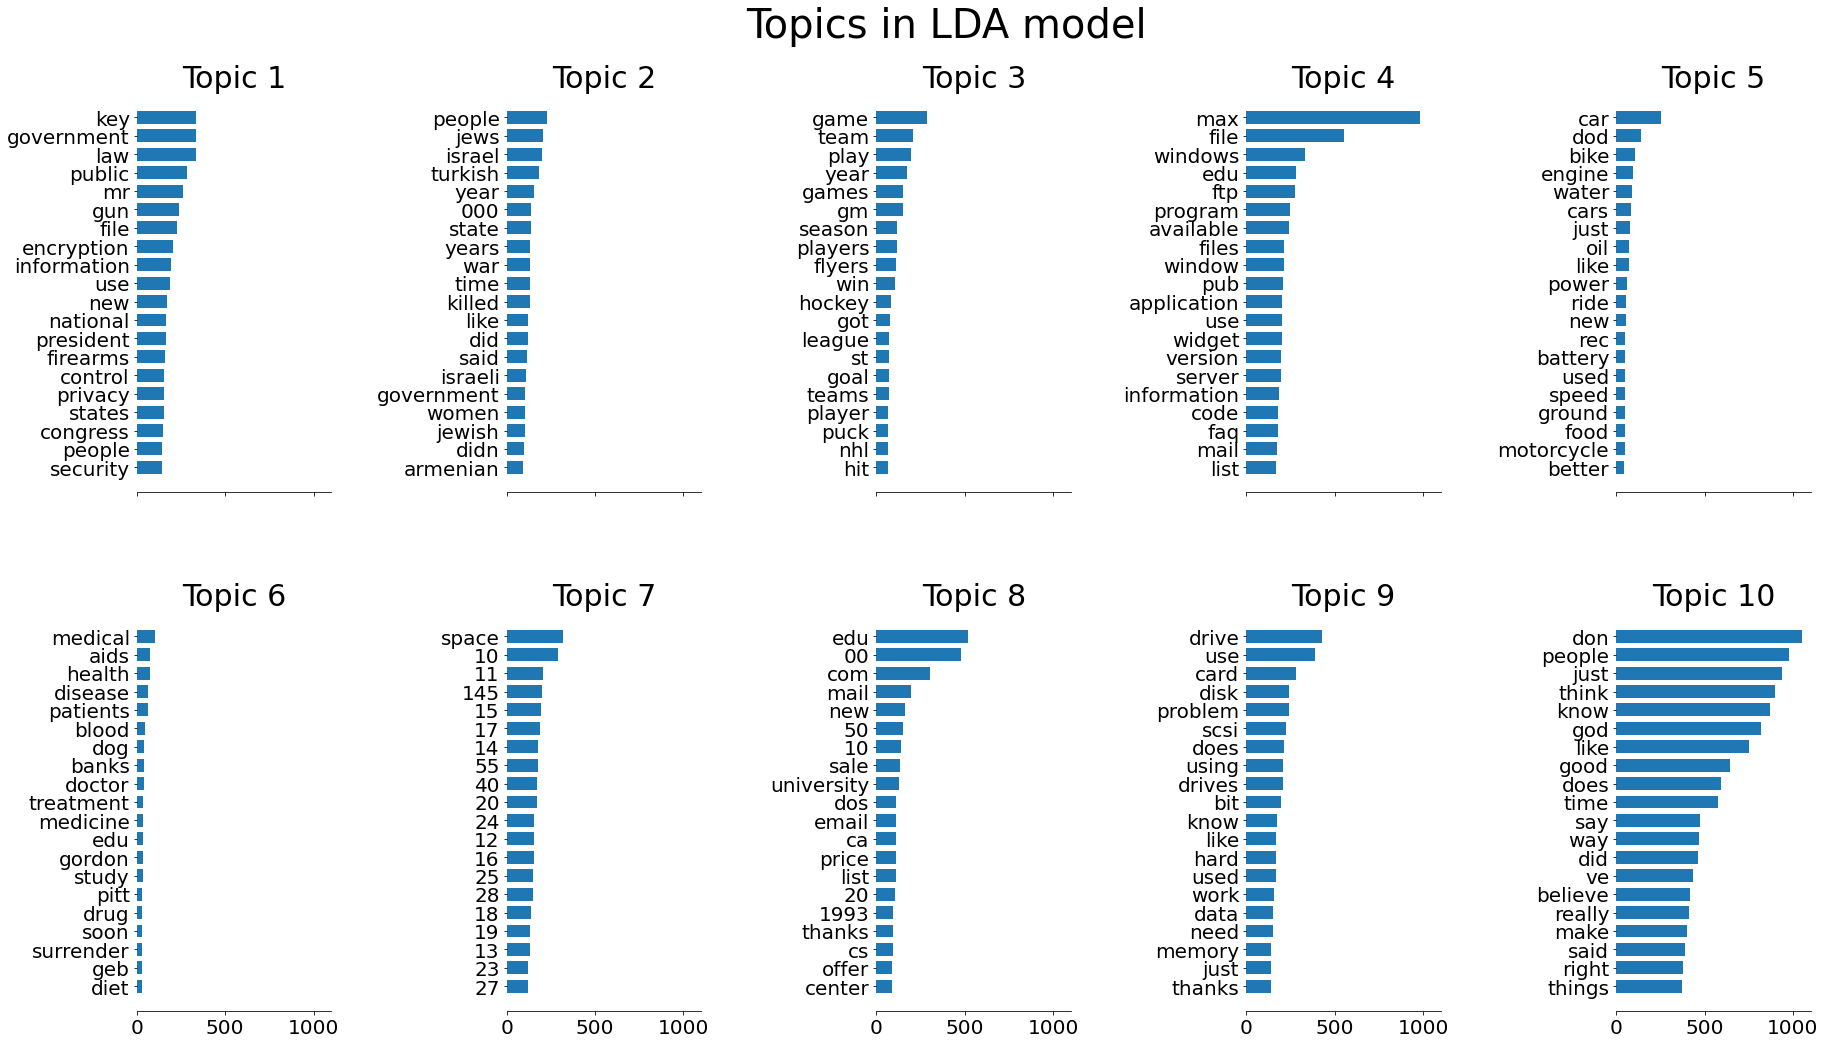

In [29]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')